In [2]:
import pandas as pd
import sqlite3

# Load the data
df = pd.read_csv("Final_Superstore_Data.csv")

# Connect to SQLite database
conn = sqlite3.connect("superstore.db")
df.to_sql("final_superstore_data", conn, if_exists="replace", index=False)

# Extract the year from the 'Order Date'
df['Year'] = pd.to_datetime(df['Order Date']).dt.year

# Convert the "Discount" column from percentage to its absolute value
df['Discount Value'] = df['Sales'] * df['Discount']

# Write the modified dataframe to SQL
df.to_sql("final_superstore_data", conn, if_exists="replace", index=False)

# SQL query to aggregate data
query = """
SELECT Year, Region, Category, SUM(`Sales`) as Total_Sales, SUM(`Discount Value`) as Total_Discount, SUM(`Profit`) as Total_Profit
FROM final_superstore_data
GROUP BY Year, Region, Category
"""

result = pd.read_sql(query, conn)
result.to_csv("EXKPI1.csv", index=False)

# Close the connection
conn.close()


In [4]:
import pandas as pd
import sqlite3

# Load the data
df = pd.read_csv("EXKPI1.csv")

# Connect to SQLite database
conn = sqlite3.connect("superstore_kpi.db")
df.to_sql("kpi_data", conn, if_exists="replace", index=False)

# SQL to organize sales by year for each region
sales_query = """
SELECT Region, 
       SUM(CASE WHEN Year = 2021 THEN Total_Sales ELSE 0 END) as Sales_2021,
       SUM(CASE WHEN Year = 2020 THEN Total_Sales ELSE 0 END) as Sales_2020,
       SUM(CASE WHEN Year = 2019 THEN Total_Sales ELSE 0 END) as Sales_2019,
       SUM(CASE WHEN Year = 2018 THEN Total_Sales ELSE 0 END) as Sales_2018
FROM kpi_data
GROUP BY Region
"""

sales_df = pd.read_sql(sales_query, conn)

# Calculate Sales Growth
sales_df["Average Sales Growth (%)"] = ((sales_df["Sales_2021"] / sales_df["Sales_2018"]) ** (1/3) - 1) * 100
sales_df["Growth2021 (%)"] = ((sales_df["Sales_2021"] - sales_df["Sales_2020"]) / sales_df["Sales_2020"]) * 100
sales_df["Performance"] = sales_df["Growth2021 (%)"].apply(lambda x: "Above Target" if x >= 10 else "Below Target")

# Calculate Profit Margin and COGS
profit_query = """
SELECT Region, 
       AVG(Total_Profit / Total_Sales * 100) as Average_Profit_Margin,
       SUM(CASE WHEN Year = 2021 THEN Total_Profit ELSE 0 END) / 
       SUM(CASE WHEN Year = 2021 THEN Total_Sales ELSE 0 END) * 100 as Profit_Margin_2021,
       AVG((Total_Sales - Total_Profit) / Total_Sales * 100) as Average_COGS,
       SUM(CASE WHEN Year = 2021 THEN (Total_Sales - Total_Profit) ELSE 0 END) / 
       SUM(CASE WHEN Year = 2021 THEN Total_Sales ELSE 0 END) * 100 as COGS_2021
FROM kpi_data
GROUP BY Region
"""

profit_df = pd.read_sql(profit_query, conn)

# Merge the dataframes
final_df = pd.merge(sales_df, profit_df, on="Region", how="inner")

# Write the final dataframe to SQL
final_df.to_sql("final_kpi_data", conn, if_exists="replace", index=False)

# Export to CSV
final_df.to_csv("Final_KPI_Table.csv", index=False)

# Close the connection
conn.close()


In [16]:
import pandas as pd
import sqlite3

# Load the data
orders_df = pd.read_excel("Copy Original Sample - Superstore.xls", sheet_name='Orders')
orders_df["Year"] = orders_df["Order Date"].dt.year

# Connect to SQLite database
conn = sqlite3.connect("superstore_retention.db")
orders_df.to_sql("orders", conn, if_exists="replace", index=False)

# For the sake of this example, let's calculate retention of customers acquired in 2018 over the years

# Get all unique customers acquired in 2018 by region
query_2018_customers = """
SELECT "Region", "Customer ID"
FROM orders
WHERE Year = 2018
GROUP BY "Region", "Customer ID"
"""
customers_2018 = pd.read_sql(query_2018_customers, conn)

# Dictionary to store results
results = {}

# Loop over regions to calculate retention
for region in customers_2018["Region"].unique():
    subset_customers = customers_2018[customers_2018["Region"] == region]
    
    retention_query = """
    SELECT Year, 
           COUNT(DISTINCT "Customer ID") as Retained_Customers
    FROM orders
    WHERE Year > 2018 AND "Customer ID" IN ({0}) AND "Region" = '{1}'
    GROUP BY Year
    ORDER BY Year
    """.format(", ".join(["'"+str(id)+"'" for id in subset_customers["Customer ID"].tolist()]), region)
    retention_df = pd.read_sql(retention_query, conn)
    
    # Calculate Retention Rate
    initial_customers_count = len(subset_customers)
    retention_df["Retention Rate (%)"] = (retention_df["Retained_Customers"] / initial_customers_count) * 100
    results[region] = retention_df

# Close the connection
conn.close()

# Display the retention rates for each region
for region, df in results.items():
    print(f"Region: {region}")
    print(df)
    print("-" * 50)


Region: Central
   Year  Retained_Customers  Retention Rate (%)
0  2019                  52           25.490196
1  2020                  56           27.450980
2  2021                  73           35.784314
--------------------------------------------------
Region: East
   Year  Retained_Customers  Retention Rate (%)
0  2019                  63           27.631579
1  2020                  80           35.087719
2  2021                  94           41.228070
--------------------------------------------------
Region: South
   Year  Retained_Customers  Retention Rate (%)
0  2019                  30           19.230769
1  2020                  37           23.717949
2  2021                  41           26.282051
--------------------------------------------------
Region: West
   Year  Retained_Customers  Retention Rate (%)
0  2019                  93           34.572491
1  2020                 126           46.840149
2  2021                 132           49.070632
-----------------------

In [17]:
# Initialize a dictionary to store average retention rates for each region
avg_retention_rates = {}

# Iterate over each region in the results
for region, df in results.items():
    avg_rate = df["Retention Rate (%)"].mean()
    avg_retention_rates[region] = avg_rate

# Convert the dictionary to a DataFrame for easier visualization
avg_retention_df = pd.DataFrame(list(avg_retention_rates.items()), columns=['Region', 'Avg Retention Rate (%)'])

# Print out the average retention rates
print(avg_retention_df)


    Region  Avg Retention Rate (%)
0  Central               29.575163
1     East               34.649123
2    South               23.076923
3     West               43.494424


In [18]:
# Specify the path for the output CSV file
output_path = "avg_retention_rates_by_region.csv"

# Export the DataFrame to CSV
avg_retention_df.to_csv(output_path, index=False)

print(f"Data exported to {output_path}")


Data exported to avg_retention_rates_by_region.csv


/Users/kei/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


              Category       Sales
West Coast  Technology  215629.348
Mountain     Furniture   22982.813
North East  Technology   144775.69


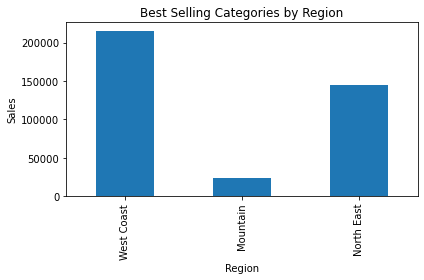

In [19]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("Final_Superstore_Data.csv")

# Connect to SQLite database
conn = sqlite3.connect("superstore.db")
df.to_sql("superstore_data", conn, if_exists="replace", index=False)

# Define a few neighboring states for demonstration purposes
# You can expand this list as needed
neighboring_states = {
    "West Coast": ["California", "Oregon", "Washington"],
    "Mountain": ["Nevada", "Arizona", "Utah"],
    "North East": ["New York", "New Jersey", "Connecticut"]
}

results = {}

# Loop through each group of neighboring states and identify the best-selling product or category
for region, states in neighboring_states.items():
    query = f"""
    SELECT Category, SUM(Sales) as TotalSales
    FROM superstore_data
    WHERE State IN ({','.join(['?' for state in states])})
    GROUP BY Category
    ORDER BY TotalSales DESC
    LIMIT 1
    """
    result = conn.execute(query, states).fetchone()
    results[region] = result

# Close the connection
conn.close()

# Create a summary DataFrame
summary_df = pd.DataFrame(results, index=["Category", "Sales"]).T
print(summary_df)

# Visualization
summary_df.plot(kind='bar', y='Sales', legend=False, title="Best Selling Categories by Region")
plt.ylabel('Sales')
plt.xlabel('Region')
plt.tight_layout()
plt.savefig("best_selling_categories_by_region.png")
plt.show()


In [31]:
# Get columns in the superstore table
query = "PRAGMA table_info(superstore);"
columns_info = pd.read_sql(query, conn)
print(columns_info)


    cid           name     type  notnull dflt_value  pk
0     0     Order Date     TEXT        0       None   0
1     1         Region     TEXT        0       None   0
2     2          State     TEXT        0       None   0
3     3           City     TEXT        0       None   0
4     4       Category     TEXT        0       None   0
5     5        Segment     TEXT        0       None   0
6     6          Sales     REAL        0       None   0
7     7       Quantity  INTEGER        0       None   0
8     8       Discount     REAL        0       None   0
9     9         Profit     REAL        0       None   0
10   10       Returned  INTEGER        0       None   0
11   11  Delivery Days  INTEGER        0       None   0
12   12           COGS     REAL        0       None   0
13   13         Margin     REAL        0       None   0


<ipython-input-32-d76bc8d598cd>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


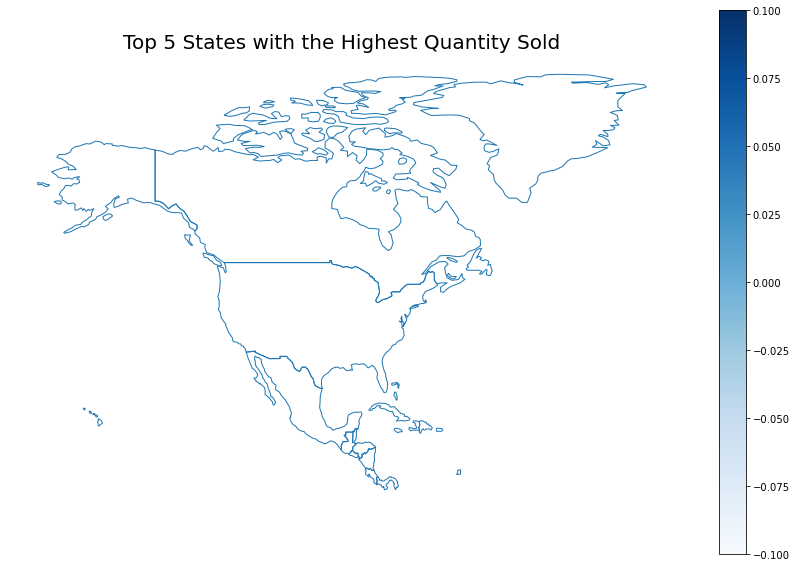

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the US states shapefile data
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = us_states[us_states['continent'] == "North America"]

# Query to get the top 5 states based on the total quantity of products sold
query = """
SELECT State, SUM(Quantity) as Total_Quantity_Sold
FROM superstore
GROUP BY State
ORDER BY Total_Quantity_Sold DESC
LIMIT 5
"""
top_quantity = pd.read_sql(query, conn)

# Merge this data with the geopandas DataFrame
merged_data = us_states.set_index('name').join(top_quantity.set_index('State'))

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
us_states.boundary.plot(ax=ax, linewidth=1)
merged_data.plot(column='Total_Quantity_Sold', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add title
plt.title('Top 5 States with the Highest Quantity Sold', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Remove axis
ax.axis('off')

# Save the map as PNG
plt.savefig("top_quantity_sold_by_state.png", dpi=300)

# Display the map
plt.show()


<ipython-input-33-921b978bf726>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


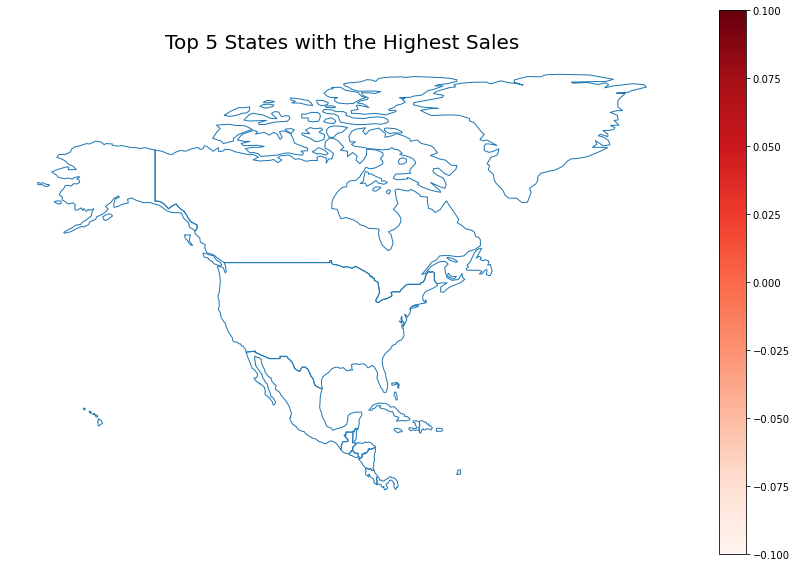

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the US states shapefile data
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = us_states[us_states['continent'] == "North America"]

# Query to get the top 5 states based on total sales
query = """
SELECT State, SUM(Sales) as Total_Sales
FROM superstore
GROUP BY State
ORDER BY Total_Sales DESC
LIMIT 5
"""
top_sales = pd.read_sql(query, conn)

# Merge this data with the geopandas DataFrame
merged_data = us_states.set_index('name').join(top_sales.set_index('State'))

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
us_states.boundary.plot(ax=ax, linewidth=1)
merged_data.plot(column='Total_Sales', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add title
plt.title('Top 5 States with the Highest Sales', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Remove axis
ax.axis('off')

# Save the map as PNG
plt.savefig("top_sales_by_state.png", dpi=300)

# Display the map
plt.show()


Pie chart saved as sales_distribution_2021.png


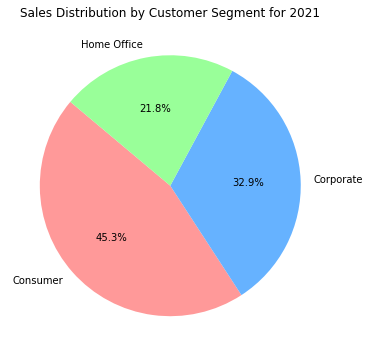

In [37]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Load the data
data_path = "Final_Superstore_Data.csv"
df = pd.read_csv(data_path)
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Year"] = df["Order Date"].dt.year

# Connect to SQLite database
conn = sqlite3.connect("superstore_2021.db")
df.to_sql("superstore", conn, if_exists="replace", index=False)

# Query to get the total sales for each segment for the year 2021
query = """
SELECT Segment, SUM(Sales) as Total_Sales
FROM superstore
WHERE Year = 2021
GROUP BY Segment
"""

# Fetch data from the database
segment_sales_2021 = pd.read_sql(query, conn)

# Plot a pie chart
plt.figure(figsize=(10, 6))
plt.pie(segment_sales_2021['Total_Sales'], labels=segment_sales_2021['Segment'], autopct='%1.1f%%', startangle=140, colors=['#FF9999', '#66B2FF', '#99FF99'])
plt.title('Sales Distribution by Customer Segment for 2021')

# Save the plot as a PNG file
plt.savefig("sales_distribution_2021.png", dpi=300, bbox_inches='tight')

# Close the database connection
conn.close()

print("Pie chart saved as sales_distribution_2021.png")
